In [1]:
from __future__ import division
import numpy as np

import posterior_agreement

from matplotlib import pyplot as plt
%matplotlib inline

# Create fake "MCMC chains"

In [2]:
# Create Npoints samples from random multivariate, nDim-dimensional Gaussian
def create_random_samples(nDim, Npoints):
    means = np.random.rand(nDim)
    cov = .5 - np.random.rand(nDim**2).reshape((nDim,nDim))
    cov = np.triu(cov)
    cov += cov.T - np.diag(cov.diagonal())
    cov = np.dot(cov,cov)
    samples =  np.random.multivariate_normal(means, cov, Npoints)
    return samples

# Create two sets of fake data with 3 parameters
np.random.seed(42) # To be able to create the same fake data over and over again
samples1 = create_random_samples(3, 50000)
samples2 = 1+create_random_samples(3, 70000)

# Random weights (for weighted example)
weights1 = np.random.rand(50000)
weights2 = np.random.rand(70000)

# Tests with unweighted (unit-weighted) samples

## One-dimensional parameter agreement
Let's find out how well both data sets agree in their first parameter!

In [3]:
chains = (samples1[:,0], samples2[:,0])
agreement_1d = posterior_agreement.compute_agreement(chains)

In [4]:
print "p-value %.3f, corresponding to %.1f sigmas"%(agreement_1d.PTE, agreement_1d.sigma)

p-value 0.410, corresponding to 0.8 sigmas


### Plot the distribution of differences
We can simply use the `evaluate_KDE` method. We also highlight the area that corresponds to the PTE.

Text(0,0.5,u'$P(\\mathrm{difference})$')

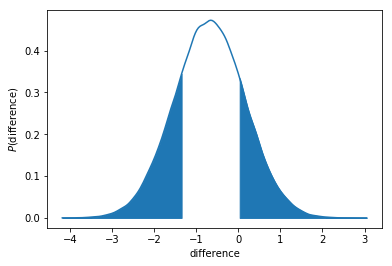

In [5]:
diff = np.linspace(agreement_1d.xmin, agreement_1d.xmax, 200)
Pdiff = agreement_1d.evaluate_DiffDist(diff)
plt.plot(diff, Pdiff)

# Get the integration limits
from scipy import optimize
level = agreement_1d.evaluate_DiffDist(0)
func = lambda x: agreement_1d.evaluate_DiffDist(x)-level
xlim = optimize.brentq(func, -3, -1)

# Left
mask = np.where(diff<xlim)
plt.fill_between(diff[mask], Pdiff[mask], color='C0')

# Right
mask = np.where(diff>0)
plt.fill_between(diff[mask], Pdiff[mask], color='C0')

plt.xlabel('difference')
plt.ylabel('$P(\mathrm{difference})$')

## Two-dimensional parameter agreement
Now let's see what the agreement is in the space of parameters one and three. Note that this may take a little while to run. If too impatient, try and play with the `nSamples` and `nBins` arguments.

In [6]:
chains = (samples1[:,[0,2]], samples2[:,[0,2]])
agreement_2d = posterior_agreement.compute_agreement(chains, nSamples=50000)

In [7]:
print "p-value %.3f, corresponding to %.1f sigmas"%(agreement_2d.PTE, agreement_2d.sigma)

p-value 0.683, corresponding to 0.4 sigmas


# Weighted samples
Now assume that our samples have weights. This could be because we used an MCMC sampler of multinest, or because we importance-sampled a chain.

We initialized the weights as random numbers [0,1), so they should have no impact on the results.

In [8]:
chains = (samples1[:,0], samples2[:,0])
weights = (weights1, weights2)
agreement_1d = posterior_agreement.compute_agreement(chains, weights=weights)

In [9]:
print "p-value %.3f, corresponding to %.1f sigmas"%(agreement_1d.PTE, agreement_1d.sigma)

p-value 0.410, corresponding to 0.8 sigmas


In [10]:
chains = (samples1[:,[0,2]], samples2[:,[0,2]])
weights = (weights1, weights2)

agreement_2d = posterior_agreement.compute_agreement(chains, weights=weights, nSamples=50000)

In [11]:
print "p-value %.3f, corresponding to %.1f sigmas"%(agreement_2d.PTE, agreement_2d.sigma)

p-value 0.674, corresponding to 0.4 sigmas


# Notes about what the number of sigmas means

## 1D analytic example
Let's draw from a one-dimensional Gaussian distribution $\mathcal N(0,1)$, and from a $\delta$ function centered at 1 or 2. We know the answer: this should give $1\sigma$ and $2\sigma$ difference. And it does!

In [12]:
samples0 = np.random.randn(10000)
samples1 = np.ones(10)
samples2 = 2*np.ones(10)

In [13]:
agreement_1d_1 = posterior_agreement.compute_agreement((samples0, samples1), nSamples=50000, nBins=60)
agreement_1d_2 = posterior_agreement.compute_agreement((samples0, samples2), nSamples=50000, nBins=60)

In [14]:
print "Example one: %.3fσ, exact solution is 1"%agreement_1d_1.sigma
print "Example two: %.3fσ, exact solution is 2"%agreement_1d_2.sigma

Example one: 1.001σ, exact solution is 1
Example two: 2.049σ, exact solution is 2


## 2D analytic example
Same exercise, but in two dimensions. Naively, you might think we should get $1\sigma$ and $2\sigma$ differences. But we don't. So what's going on? Well, remember we are asking what the probability to exceed zero difference is, and we convert this $p$-value to sigmas. We are not asking whether 0 difference coincides with the $1\sigma$ or $2\sigma$ isocontour.

In [15]:
cov = [[1,0], [0,1]]
samples0 =  np.random.multivariate_normal([0,0], cov, 50000)
samples1 = np.concatenate((np.ones(10)[:,None],np.zeros(10)[:,None]), axis=1)

In [16]:
agreement_2d_1 = posterior_agreement.compute_agreement((samples0, samples1), nSamples=50000, nBins=60)

In [17]:
print "Example one: PTE %.3f, %.3fσ"%(agreement_2d_1.PTE, agreement_2d_1.sigma)

Example one: PTE 0.615, 0.503σ
